In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
from mysql.connector import IntegrityError
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, classification_report, confusion_matrix

In [2]:
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

In [3]:
# Establish MySQL connection
db_connection = mysql.connector.connect(
    host="localhost",
    user="root",
    password="password", # please use your password
    database="fraud_detection")
cursor = db_connection.cursor()

In [4]:
# Load datasets and store in MySQL tables
def load_to_sql(file_name, table_name, columns):
    df = pd.read_csv(file_name)
    
    # Generate SQL INSERT query 
    placeholders = ', '.join(['%s'] * len(columns))
    insert_query = f"INSERT INTO {table_name} ({', '.join(columns)}) VALUES ({placeholders})"
    
    for _, row in df.iterrows():
        try:
            cursor.execute(insert_query, tuple(row))
        except mysql.connector.IntegrityError:
            print(f"Skipping duplicate entry in {table_name}: {tuple(row)}")
    
    db_connection.commit()
    print(f"✅ Data inserted into {table_name} ({len(df)} rows, skipping duplicates)")
    return df

# Load data into MySQL tables
df_transactions = load_to_sql('transaction_records.csv', 'transactions', ['TransactionID', 'Amount', 'CustomerID'])
df_metadata = load_to_sql('transaction_metadata.csv', 'metadata', ['TransactionID', 'Timestamp', 'MerchantID'])
df_fraud = load_to_sql('fraud_indicators.csv', 'fraud', ['TransactionID', 'FraudIndicator'])
df_suspicious = load_to_sql('suspicious_activity.csv', 'suspicious', ['CustomerID', 'SuspiciousFlag'])
df_anomalies = load_to_sql('anomaly_scores.csv', 'anomalies', ['TransactionID', 'AnomalyScore'])

# Join data using SQL query
query = """
SELECT t.*, m.Timestamp, m.MerchantID, f.FraudIndicator, a.AnomalyScore
FROM transactions t
JOIN metadata m ON t.TransactionID = m.TransactionID
JOIN fraud f ON t.TransactionID = f.TransactionID
JOIN anomalies a ON t.TransactionID = a.TransactionID
"""
df = pd.read_sql(query, db_connection)

Skipping duplicate entry in transactions: (1.0, 55.530334429869185, 1952.0)
Skipping duplicate entry in transactions: (2.0, 12.881180192784145, 1027.0)
Skipping duplicate entry in transactions: (3.0, 50.176321517065674, 1955.0)
Skipping duplicate entry in transactions: (4.0, 41.63400105303006, 1796.0)
Skipping duplicate entry in transactions: (5.0, 78.12285326574603, 1946.0)
Skipping duplicate entry in transactions: (6.0, 86.94708413376785, 1204.0)
Skipping duplicate entry in transactions: (7.0, 51.1470964781812, 1311.0)
Skipping duplicate entry in transactions: (8.0, 56.163984308348134, 1693.0)
Skipping duplicate entry in transactions: (9.0, 37.182411723100415, 1347.0)
Skipping duplicate entry in transactions: (10.0, 17.245409041786953, 1574.0)
Skipping duplicate entry in transactions: (11.0, 86.18094790838266, 1424.0)
Skipping duplicate entry in transactions: (12.0, 95.55400891993546, 1302.0)
Skipping duplicate entry in transactions: (13.0, 47.13851441157395, 1321.0)
Skipping duplica

In [5]:
# Data Overview
print("Data Overview:")
print(df.head())
print("\nMissing Values:")
print(df.isnull().sum())

Data Overview:
   TransactionID  Amount  CustomerID           Timestamp  MerchantID  \
0              1   55.53        1952 2022-01-01 00:00:00        2701   
1              2   12.88        1027 2022-01-01 01:00:00        2070   
2              3   50.18        1955 2022-01-01 02:00:00        2238   
3              4   41.63        1796 2022-01-01 03:00:00        2879   
4              5   78.12        1946 2022-01-01 04:00:00        2966   

   FraudIndicator  AnomalyScore  
0               0      0.686699  
1               0      0.081749  
2               0      0.023857  
3               0      0.876994  
4               0      0.034059  

Missing Values:
TransactionID     0
Amount            0
CustomerID        0
Timestamp         0
MerchantID        0
FraudIndicator    0
AnomalyScore      0
dtype: int64


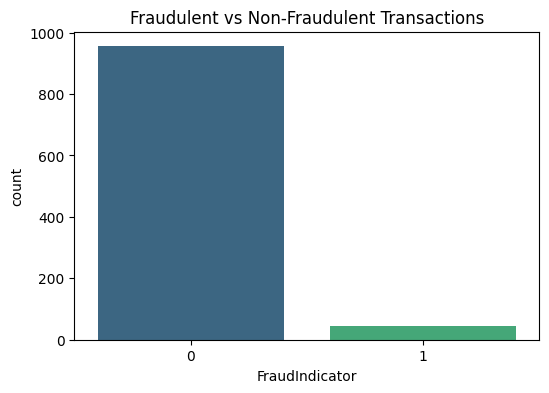

In [6]:
# Visualizing Fraud Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='FraudIndicator', data=df, palette='viridis')
plt.title('Fraudulent vs Non-Fraudulent Transactions')
plt.show()

In [7]:
# Feature Engineering
features = ['Amount', 'AnomalyScore'] 
X = df[features]
y = df['FraudIndicator']

In [8]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77)

In [9]:

# Define multiple models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=77),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=77),
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB(),
    "Ridge Classifier": RidgeClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Neural Network (MLP)": MLPClassifier(max_iter=500)
}

In [10]:
# Store results
results = []

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=1, average='weighted')
    recall = recall_score(y_test, y_pred, zero_division=1, average='weighted')
    f1 = f1_score(y_test, y_pred, zero_division=1, average='weighted')
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    results.append([name, accuracy, precision, recall, f1, rmse])
    
    print(f"\n{name} Model Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


Random Forest Model Performance:
Accuracy: 0.9600
Precision: 0.9616
Recall: 0.9600
F1 Score: 0.9404
RMSE: 0.2000
Confusion Matrix:
[[192   0]
 [  8   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       192
           1       0.00      0.00      0.00         8

    accuracy                           0.96       200
   macro avg       0.48      0.50      0.49       200
weighted avg       0.92      0.96      0.94       200


Gradient Boosting Model Performance:
Accuracy: 0.9600
Precision: 0.9616
Recall: 0.9600
F1 Score: 0.9404
RMSE: 0.2000
Confusion Matrix:
[[192   0]
 [  8   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       192
           1       0.00      0.00      0.00         8

    accuracy                           0.96       200
   macro avg       0.48      0.50      0.49       200
weighted avg       0.92      0.96      0.

In [11]:
# Create a DataFrame to display results
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "RMSE"])
print("\nModel Performance Table:")
print(results_df)

# Find best model based on all metrics
best_model = results_df.set_index("Model").mean(axis=1).idxmax()
print(f"\nBest Model Overall: {best_model} with Scores:\n{results_df.loc[results_df['Model'] == best_model]}")

# Close database connection
db_connection.close()


Model Performance Table:
                  Model  Accuracy  Precision  Recall  F1 Score      RMSE
0         Random Forest     0.960   0.961600   0.960  0.940408  0.200000
1     Gradient Boosting     0.960   0.961600   0.960  0.940408  0.200000
2   Logistic Regression     0.960   0.961600   0.960  0.940408  0.200000
3                   SVM     0.960   0.961600   0.960  0.940408  0.200000
4   K-Nearest Neighbors     0.960   0.961600   0.960  0.940408  0.200000
5         Decision Tree     0.945   0.941584   0.945  0.943238  0.234521
6           Naive Bayes     0.960   0.961600   0.960  0.940408  0.200000
7      Ridge Classifier     0.960   0.961600   0.960  0.940408  0.200000
8              AdaBoost     0.960   0.961600   0.960  0.940408  0.200000
9  Neural Network (MLP)     0.960   0.961600   0.960  0.940408  0.200000

Best Model Overall: Random Forest with Scores:
           Model  Accuracy  Precision  Recall  F1 Score  RMSE
0  Random Forest      0.96     0.9616    0.96  0.940408   0.2